# 2. Multi object detection

This notebook is motivated by fast.ai's course.

In [1]:
%matplotlib inline
# % load_ext autoreload
# % autoreload 2

In [2]:
import torch
import voc
from pathlib import Path

import numpy as np
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Pick one

In [3]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

### 1. Defining the datasets

The dataset objects take as input a mask, which allow me to split the data into training and validation data.

In [4]:
total_dataset = voc.datasets.VOCDataset()

Now that we know the size of the dataset, we can use this to create a mask

In [5]:
train_mask = np.random.rand(len(total_dataset)) < 0.8
val_mask = ~train_mask

In [6]:
train_images = voc.datasets.MultiImageDataset(mask=train_mask, normalizer='imagenet', 
                                         random_transform=True, resize=(224, 224), device=device)

In [7]:
label2class = train_images.get_labels_from_classes()
normalizer = train_images.get_normalizer()
class2label = {int(im_class): label for label, im_class in label2class.items()}

In [8]:
val_images = voc.datasets.MultiImageDataset(mask=val_mask, normalizer='imagenet', resize=(224, 224),
                                       label2class=label2class, device=device)

In [9]:
im, bbs, labs = train_images.__getitem__(10)

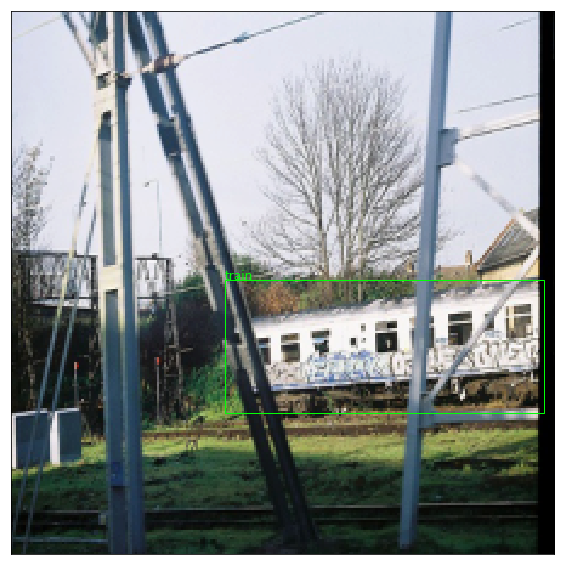

In [10]:
txt_labs = [class2label[idx.item()] for idx in labs]
denormed_im = voc.utils.denormalize(im.cpu().numpy(), mean=normalizer['mean'], std=normalizer['std'])
voc.explore.plot_image(denormed_im, bbs.cpu().numpy(), txt_labs)

Awesome. Now, in order to figure out which activations should find each of these objects, I need to do the following:

- Figure out what my **base** anchor boxes are going to be.
- Figure out what my **permuted** anchor boxes are going to be.

Then,

- Assign each ground truth bounding box to a **permuted** bounding box anchor

### 2.1. Getting the base bounding boxes, and their permutations

I am going to do this across 3 'depths', but I'll only visualize the `2 x 2` activations, to prevent the overlap from being confusing.

I'll start by considering an image of size `(1, 1)`, which I can then multiply by 224 to reflect the resnet-processed images.

In [9]:
import numpy as np

In [10]:
anchors_4 = voc.utils.make_anchors(224, 224, 0.25)
anchors_2 = voc.utils.make_anchors(224, 224, 0.5)
anchors_1 = voc.utils.make_anchors(224, 224, 1)

anchors = np.vstack((anchors_4, anchors_2, anchors_1))

Lets plot these bounding boxes, to see what they look like

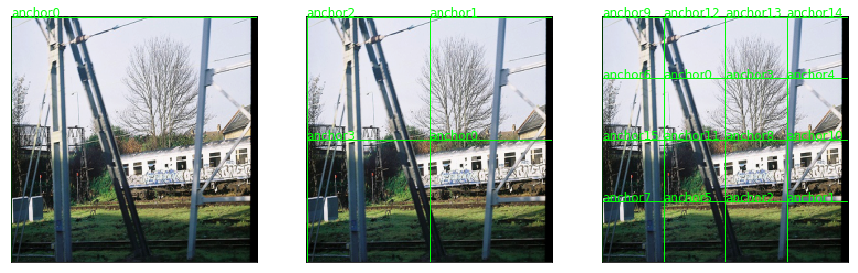

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

voc.explore.plot_image(denormed_im, anchors_1, labels=['anchor' + str(i) for i in range(len(anchors_1))], ax=ax[0])
voc.explore.plot_image(denormed_im, anchors_2, labels=['anchor' + str(i) for i in range(len(anchors_2))], ax=ax[1])
voc.explore.plot_image(denormed_im, anchors_4, labels=['anchor' + str(i) for i in range(len(anchors_4))], ax=ax[2])

Lets take a look at what these permuted anchors look like for the `2x2` boxes:

In [14]:
pm_anc_2, num_permutations = voc.utils.permute_anchors(anchors_2, zooms=[1.3, 1., 0.7], 
                                                       ratios=[(1., 1.), (0.5, 1.), (1., 0.5)])

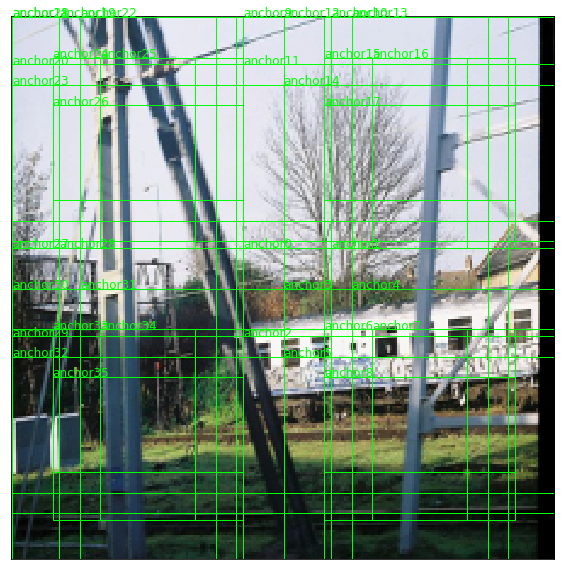

In [15]:
voc.explore.plot_image(denormed_im, pm_anc_2, labels=['anchor' + str(i) for i in range(len(pm_anc_2))])

Now, for all the boxes:

In [11]:
pm_anc, num_permutations = voc.utils.permute_anchors(anchors, zooms=[0.7, 1, 1.3], 
                                                     ratios=[(1., 1.), (0.5, 1.), (1., 0.5)])

In [12]:
num_permutations

9

In [13]:
pm_anc_tensor = torch.from_numpy(pm_anc).float().cuda()

Now that I have defined these anchor boxes, I can find the minimum and maximum learning rates

In [14]:
test_ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

In [15]:
criterion = voc.models.SSDLoss(anchors=pm_anc_tensor, threshold=0.4, num_classes=len(label2class), device=device)

In [16]:
test_dataloader = DataLoader(train_images, batch_size=64, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)

In [22]:
starting_learning_rate = 1e-5
ending_learning_rate = 1

total_loss = []
learning_rate_progression = []

parameters_to_update = [parameters for name, parameters in test_ssd.named_parameters() if 'pretrained' not in name]

for batch_number, batch in (enumerate(tqdm(test_dataloader))):
    
        addition = (batch_number / len(test_dataloader)) * (ending_learning_rate - starting_learning_rate)
        learning_rate = starting_learning_rate + addition
        # create a new optimizer with higher learning rates
        optimizer = torch.optim.Adam(parameters_to_update, lr=learning_rate)
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = test_ssd(ims)
        bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
        loss = bb_loss + label_loss
        learning_rate_progression.append(learning_rate)
        total_loss.append(loss)
        loss.backward()
        optimizer.step()

100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


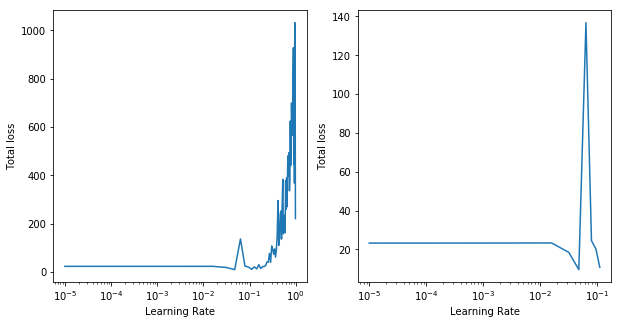

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# First, lets plot the results from the whole test
axes[0].plot(learning_rate_progression, total_loss)
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Total loss')
axes[0].set_xscale('log')

# then, clipped
axes[1].plot(learning_rate_progression[:8], total_loss[:8])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Total loss')
axes[1].set_xscale('log')

In [17]:
min_lr = 1e-5
max_lr = 1e-2

In addition, I am going to find the weight (`alpha` in the SSD paper)

In [18]:
# once again, defining a test model
test_ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

                
stepsize = int(len(test_dataloader) + 1 / 2)
parameters_to_update = [parameters for name, parameters in test_ssd.named_parameters() if 'pretrained' not in name]
optimizer = torch.optim.Adam(parameters_to_update)
cl_scheduler = voc.schedulers.CyclicalLR(optimizer, stepsize, min_lr, max_lr)

for batch_number, batch in (enumerate(tqdm(test_dataloader))):
    # Zero the gradients of my optimizer - 'reset' it
    optimizer.zero_grad()

    ims, target_bb, target_label = batch
    output_bb, output_labels = test_ssd(ims)

    bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
    loss = bb_loss + label_loss
    loss.backward()
    optimizer.step()
    # note that the step happens every batch, not every epoch
    cl_scheduler.step()

100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


In [19]:
loss_weight = (bb_loss / label_loss).detach()

In [20]:
loss_weight

tensor(9.2487, device='cuda:0')

Now, we can define our model, and our optimizer

In [21]:
ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

Using Xavier initialization for the non-pretrained layers

In [22]:
# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

In [23]:
train_dataloader = DataLoader(train_images, batch_size=32, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)
val_dataloader = DataLoader(val_images, batch_size=32, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)

In [24]:
parameters_to_update = [parameters for name, parameters in ssd.named_parameters() if 'pretrained' not in name]
optimizer = torch.optim.Adam(parameters_to_update)

In [25]:
stepsize = int(len(train_dataloader) + 1 / 2)

In [26]:
cl_scheduler = voc.schedulers.CyclicalLR(optimizer, stepsize, min_lr, max_lr)

In [27]:
lr_change = cl_scheduler.test()

Text(0,0.5,'Learning rate')

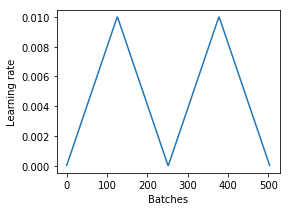

In [28]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(len(lr_change)), lr_change)
ax.set_xlabel('Batches')
ax.set_ylabel('Learning rate')

Finally, I can train the model

In [29]:
num_epochs = 100
patience = 5
best_val_loss = np.inf
patience_counter = 0

In [30]:
for epoch in range(num_epochs):
    # set model to train
    ssd.train()

    # Keep track of my loss, so I can display it
    running_train_scores = defaultdict(list)
    
    # Iterate through my batches
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = ssd(ims)

        bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
        loss = bb_loss + (loss_weight * label_loss)
        loss.backward()
        optimizer.step()
        # For display purposes:
        running_train_scores['loss'].append(loss.item())
        running_train_scores['bb_loss'].append(bb_loss.item())
        running_train_scores['label_loss'].append(label_loss.item())
        # note that the step happens every batch, not every epoch
        cl_scheduler.step()

    train_output_strings = []
    for key, val in running_train_scores.items():
        train_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))

    # now, lets see how we did on the validation set
    if val_dataloader:
        ssd.eval()
        running_val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in (enumerate(val_dataloader)):
                val_ims, val_bb, val_lab = batch
                output_bb, output_labels = ssd(val_ims)
                val_bb_loss, val_label_loss = criterion(val_bb, val_lab, output_bb, output_labels)
                val_loss = val_bb_loss + (loss_weight * val_label_loss)
                running_val_scores['loss'].append(val_loss)
                running_val_scores['bb_loss'].append(val_bb_loss)
                running_val_scores['label_loss'].append(val_label_loss)
                
            # early stopping
            total_val_loss = np.array(running_val_scores['loss']).mean()
            if total_val_loss < best_val_loss:
                print('Saving model')
                best_val_loss = total_val_loss
                patience_counter = 0
                model_information = {
                    'state_dict': ssd.state_dict()
                }
                torch.save(model_information, 'ssd.pth.tar')
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print('Early stopping')
                    break
            
        val_output_strings = []
        for key, val in running_val_scores.items():
            val_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 9.15924, bb_loss: 0.68731, label_loss: 0.91601
VALIDATION: loss: 1.6505999565124512, bb_loss: 1.0019999742507935, label_loss: 0.07012999802827835


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.51604, bb_loss: 0.86516, label_loss: 0.07038
VALIDATION: loss: 1.2382099628448486, bb_loss: 0.6301599740982056, label_loss: 0.06573999673128128


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.32857, bb_loss: 0.70401, label_loss: 0.06753
VALIDATION: loss: 1.3004200458526611, bb_loss: 0.7019799947738647, label_loss: 0.06470999866724014


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.24665, bb_loss: 0.63827, label_loss: 0.06578
VALIDATION: loss: 1.063789963722229, bb_loss: 0.49845001101493835, label_loss: 0.06112999841570854


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.14432, bb_loss: 0.55452, label_loss: 0.06377
VALIDATION: loss: 1.1149400472640991, bb_loss: 0.5382999777793884, label_loss: 0.06235000118613243


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.1205, bb_loss: 0.52969, label_loss: 0.06388
VALIDATION: loss: 1.0103800296783447, bb_loss: 0.46592000126838684, label_loss: 0.05886999890208244


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.07937, bb_loss: 0.50789, label_loss: 0.06179
VALIDATION: loss: 1.053320050239563, bb_loss: 0.49564000964164734, label_loss: 0.06030000001192093


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.06627, bb_loss: 0.50254, label_loss: 0.06095
VALIDATION: loss: 0.9679700136184692, bb_loss: 0.4442099928855896, label_loss: 0.05663000047206879


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.02805, bb_loss: 0.47826, label_loss: 0.05945
VALIDATION: loss: 1.0256500244140625, bb_loss: 0.4916900098323822, label_loss: 0.05773000046610832


100%|██████████| 126/126 [01:47<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.03316, bb_loss: 0.48796, label_loss: 0.05895
VALIDATION: loss: 0.9351500272750854, bb_loss: 0.4300200045108795, label_loss: 0.05462000146508217


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.99532, bb_loss: 0.4694, label_loss: 0.05686
VALIDATION: loss: 0.9826800227165222, bb_loss: 0.4646399915218353, label_loss: 0.05601000040769577


100%|██████████| 126/126 [01:46<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.99774, bb_loss: 0.47367, label_loss: 0.05666
VALIDATION: loss: 0.9108399748802185, bb_loss: 0.42493999004364014, label_loss: 0.05254000052809715


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.94896, bb_loss: 0.43897, label_loss: 0.05514
VALIDATION: loss: 0.972000002861023, bb_loss: 0.45680001378059387, label_loss: 0.055709999054670334


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.95762, bb_loss: 0.44522, label_loss: 0.0554
VALIDATION: loss: 0.8549100160598755, bb_loss: 0.3776499927043915, label_loss: 0.051600001752376556


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.89425, bb_loss: 0.39501, label_loss: 0.05398
VALIDATION: loss: 0.8772799968719482, bb_loss: 0.3752000033855438, label_loss: 0.05429000034928322


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.841, bb_loss: 0.33095, label_loss: 0.05515
VALIDATION: loss: 0.6920400261878967, bb_loss: 0.214819997549057, label_loss: 0.051600001752376556


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.77423, bb_loss: 0.27148, label_loss: 0.05436
VALIDATION: loss: 0.7269999980926514, bb_loss: 0.23179000616073608, label_loss: 0.05353999882936478


100%|██████████| 126/126 [01:49<00:00,  1.16it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.75516, bb_loss: 0.25188, label_loss: 0.05442
VALIDATION: loss: 0.6370099782943726, bb_loss: 0.17003999650478363, label_loss: 0.05048999935388565


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.71837, bb_loss: 0.22704, label_loss: 0.05312
VALIDATION: loss: 0.7075200080871582, bb_loss: 0.22718000411987305, label_loss: 0.05194000154733658


100%|██████████| 126/126 [01:47<00:00,  1.17it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.72369, bb_loss: 0.23217, label_loss: 0.05314
VALIDATION: loss: 0.6202499866485596, bb_loss: 0.158610001206398, label_loss: 0.04991000145673752


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.69051, bb_loss: 0.20751, label_loss: 0.05222
VALIDATION: loss: 0.6732199788093567, bb_loss: 0.19774000346660614, label_loss: 0.0514100007712841


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.69778, bb_loss: 0.21367, label_loss: 0.05234
VALIDATION: loss: 0.6047899723052979, bb_loss: 0.1491599977016449, label_loss: 0.04926000162959099


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.67028, bb_loss: 0.19365, label_loss: 0.05153
VALIDATION: loss: 0.6494600176811218, bb_loss: 0.18503999710083008, label_loss: 0.050209999084472656


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.68934, bb_loss: 0.20873, label_loss: 0.05196
VALIDATION: loss: 0.5962600111961365, bb_loss: 0.14729000627994537, label_loss: 0.04853999987244606


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.661, bb_loss: 0.18658, label_loss: 0.05129
VALIDATION: loss: 0.6637099981307983, bb_loss: 0.18490000069141388, label_loss: 0.05177000164985657


100%|██████████| 126/126 [01:47<00:00,  1.17it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.67774, bb_loss: 0.20167, label_loss: 0.05147
VALIDATION: loss: 0.5913299918174744, bb_loss: 0.14483000338077545, label_loss: 0.04828000068664551


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.65179, bb_loss: 0.18731, label_loss: 0.05022
VALIDATION: loss: 0.6608099937438965, bb_loss: 0.19555999338626862, label_loss: 0.0502999983727932


100%|██████████| 126/126 [01:46<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.6607, bb_loss: 0.19672, label_loss: 0.05017
VALIDATION: loss: 0.5886099934577942, bb_loss: 0.14422999322414398, label_loss: 0.04805000126361847


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.64356, bb_loss: 0.1829, label_loss: 0.04981
VALIDATION: loss: 0.6464999914169312, bb_loss: 0.1754699945449829, label_loss: 0.050930000841617584


100%|██████████| 126/126 [01:46<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.66108, bb_loss: 0.19704, label_loss: 0.05017
VALIDATION: loss: 0.5833600163459778, bb_loss: 0.14238999783992767, label_loss: 0.047680001705884933


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.6359, bb_loss: 0.18035, label_loss: 0.04926
VALIDATION: loss: 0.651199996471405, bb_loss: 0.17789000272750854, label_loss: 0.051180001348257065


100%|██████████| 126/126 [01:47<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.65461, bb_loss: 0.19383, label_loss: 0.04982
VALIDATION: loss: 0.5806099772453308, bb_loss: 0.14353999495506287, label_loss: 0.04726000130176544


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.62827, bb_loss: 0.18011, label_loss: 0.04846
VALIDATION: loss: 0.6557000279426575, bb_loss: 0.17924000322818756, label_loss: 0.05152000114321709


100%|██████████| 126/126 [01:46<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.65234, bb_loss: 0.19573, label_loss: 0.04937
VALIDATION: loss: 0.5769000053405762, bb_loss: 0.14274999499320984, label_loss: 0.046939998865127563


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.62303, bb_loss: 0.17715, label_loss: 0.04821
VALIDATION: loss: 0.638480007648468, bb_loss: 0.18234999477863312, label_loss: 0.049320001155138016


100%|██████████| 126/126 [01:47<00:00,  1.17it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.64738, bb_loss: 0.19471, label_loss: 0.04894
VALIDATION: loss: 0.574209988117218, bb_loss: 0.14154000580310822, label_loss: 0.04678000137209892


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.61677, bb_loss: 0.17723, label_loss: 0.04752
VALIDATION: loss: 0.6603500247001648, bb_loss: 0.1767899990081787, label_loss: 0.0522800013422966


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.64115, bb_loss: 0.19283, label_loss: 0.04847
VALIDATION: loss: 0.5712599754333496, bb_loss: 0.13979999721050262, label_loss: 0.0466499999165535


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.61286, bb_loss: 0.17642, label_loss: 0.04719
VALIDATION: loss: 0.6520299911499023, bb_loss: 0.1919499933719635, label_loss: 0.04975000023841858


100%|██████████| 126/126 [01:46<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.63991, bb_loss: 0.1923, label_loss: 0.0484
VALIDATION: loss: 0.5710300207138062, bb_loss: 0.1409599930047989, label_loss: 0.04650000110268593


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.61326, bb_loss: 0.17748, label_loss: 0.04712
VALIDATION: loss: 0.6350200176239014, bb_loss: 0.1766200065612793, label_loss: 0.049559999257326126


100%|██████████| 126/126 [01:46<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.63331, bb_loss: 0.18814, label_loss: 0.04813
VALIDATION: loss: 0.5698300004005432, bb_loss: 0.13986000418663025, label_loss: 0.04648999869823456


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.60352, bb_loss: 0.1725, label_loss: 0.0466
VALIDATION: loss: 0.6442199945449829, bb_loss: 0.17425000667572021, label_loss: 0.05081000179052353


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.63524, bb_loss: 0.18985, label_loss: 0.04816
VALIDATION: loss: 0.5695400238037109, bb_loss: 0.13977999985218048, label_loss: 0.046470001339912415


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.60212, bb_loss: 0.17191, label_loss: 0.04652
VALIDATION: loss: 0.657729983329773, bb_loss: 0.1882299929857254, label_loss: 0.05076000094413757


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.62569, bb_loss: 0.19031, label_loss: 0.04707
VALIDATION: loss: 0.5675399899482727, bb_loss: 0.1391099989414215, label_loss: 0.04631999880075455


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.60091, bb_loss: 0.17299, label_loss: 0.04627
VALIDATION: loss: 0.6221399903297424, bb_loss: 0.17267000675201416, label_loss: 0.04859999939799309


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.62872, bb_loss: 0.18935, label_loss: 0.04751
VALIDATION: loss: 0.5643799901008606, bb_loss: 0.13821999728679657, label_loss: 0.04608000069856644


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.59522, bb_loss: 0.16967, label_loss: 0.04601
VALIDATION: loss: 0.6630100011825562, bb_loss: 0.1739400029182434, label_loss: 0.052880000323057175


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.62647, bb_loss: 0.18745, label_loss: 0.04747
VALIDATION: loss: 0.5617700219154358, bb_loss: 0.13707999885082245, label_loss: 0.0459199994802475


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.59217, bb_loss: 0.16873, label_loss: 0.04578
VALIDATION: loss: 0.6323400139808655, bb_loss: 0.1703599989414215, label_loss: 0.049949999898672104


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.62019, bb_loss: 0.18535, label_loss: 0.04702
VALIDATION: loss: 0.5664299726486206, bb_loss: 0.14135999977588654, label_loss: 0.04596000164747238


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.58479, bb_loss: 0.16878, label_loss: 0.04498
VALIDATION: loss: 0.6492199897766113, bb_loss: 0.1717900037765503, label_loss: 0.0516199991106987


100%|██████████| 126/126 [01:47<00:00,  1.18it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.61862, bb_loss: 0.18704, label_loss: 0.04666
VALIDATION: loss: 0.5596799850463867, bb_loss: 0.1382800042629242, label_loss: 0.045559998601675034


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.58456, bb_loss: 0.16768, label_loss: 0.04507
VALIDATION: loss: 0.6369600296020508, bb_loss: 0.17124000191688538, label_loss: 0.050360001623630524


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.61998, bb_loss: 0.18546, label_loss: 0.04698
VALIDATION: loss: 0.5621500015258789, bb_loss: 0.13741999864578247, label_loss: 0.0459199994802475


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.58259, bb_loss: 0.16913, label_loss: 0.0447
VALIDATION: loss: 0.6387699842453003, bb_loss: 0.17418000102043152, label_loss: 0.0502300001680851


100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.61386, bb_loss: 0.18717, label_loss: 0.04614
VALIDATION: loss: 0.5594499707221985, bb_loss: 0.13752999901771545, label_loss: 0.04562000185251236


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.57605, bb_loss: 0.16507, label_loss: 0.04444
VALIDATION: loss: 0.6805999875068665, bb_loss: 0.1800999939441681, label_loss: 0.05412000045180321


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.61682, bb_loss: 0.18799, label_loss: 0.04637
VALIDATION: loss: 0.5612199902534485, bb_loss: 0.13787999749183655, label_loss: 0.04577000066637993


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.58169, bb_loss: 0.16612, label_loss: 0.04493
VALIDATION: loss: 0.6586300134658813, bb_loss: 0.1855500042438507, label_loss: 0.05115000158548355


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.61236, bb_loss: 0.18891, label_loss: 0.04578
VALIDATION: loss: 0.5608000159263611, bb_loss: 0.13613000512123108, label_loss: 0.0459199994802475


100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Early stopping


In [31]:
imagenet = train_images.get_normalizer()

In [32]:
model = torch.load('ssd.pth.tar')
trained_model = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()
trained_model.load_state_dict(model['state_dict'])

In [33]:
trained_model.eval();

In [34]:
val_ims, bbs, labels = next(iter(val_dataloader))

In [35]:
with torch.no_grad():
    output_bb, output_labels = trained_model(val_ims)

In [36]:
bb_to_plot = output_bb[10:20]
lab_to_plot = output_labels[10:20]
im_to_plot = val_ims[10:20].detach().cpu().numpy()

In [37]:
denormed_ims = [voc.utils.denormalize(im, imagenet['mean'], imagenet['std']) for im in im_to_plot]

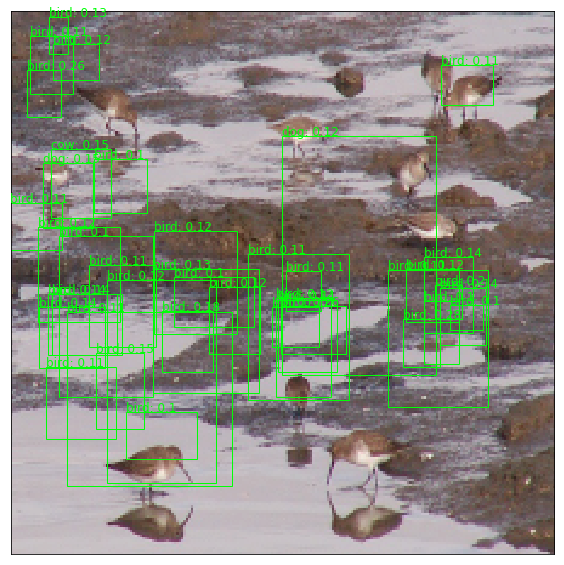

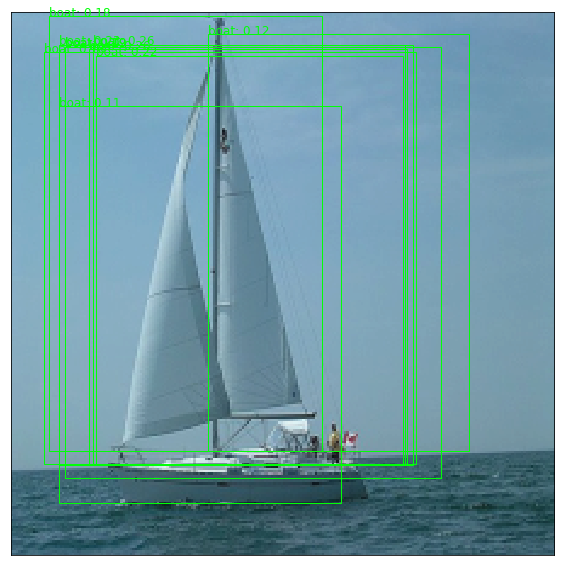

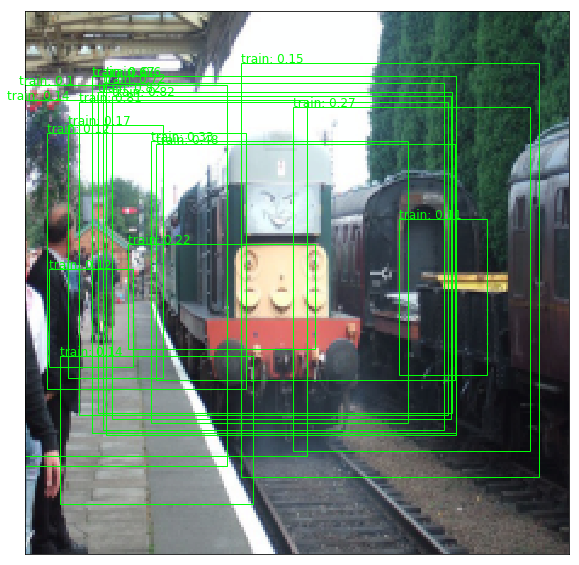

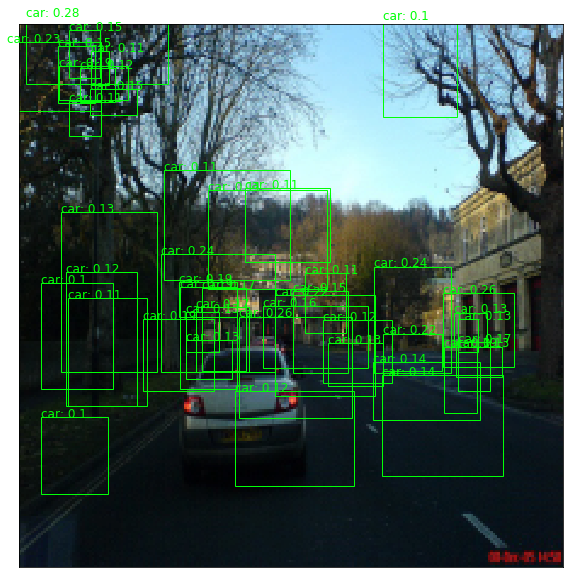

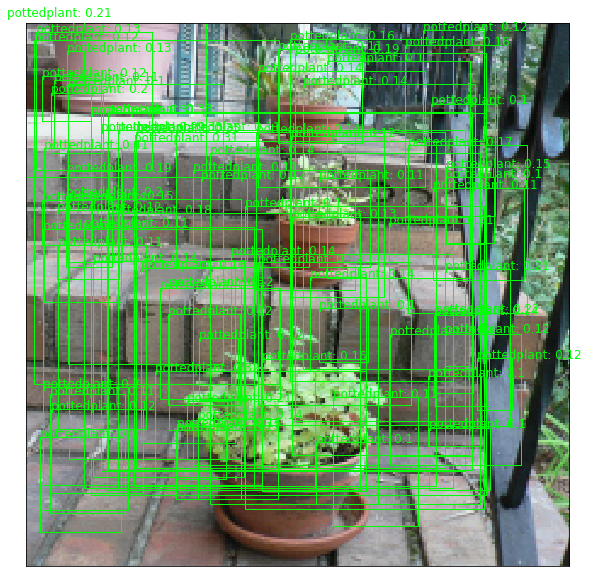

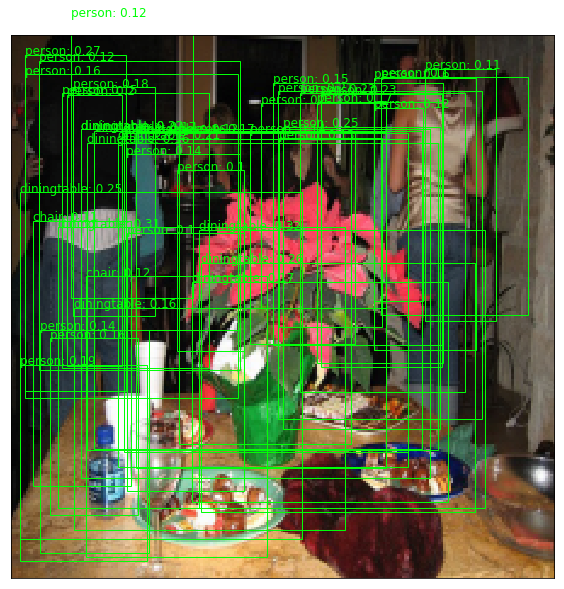

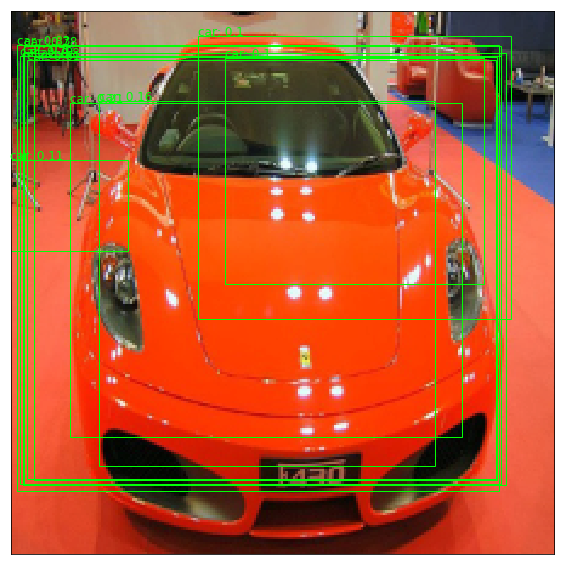

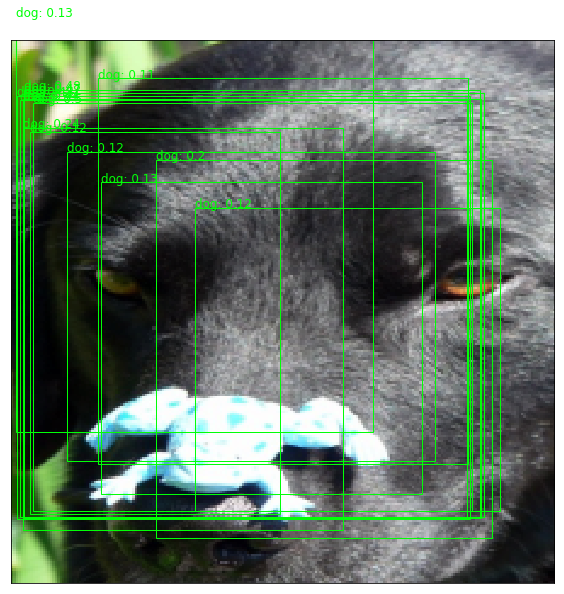

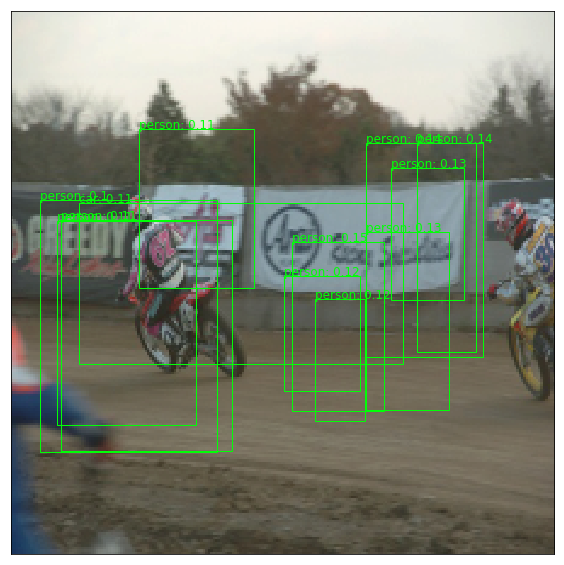

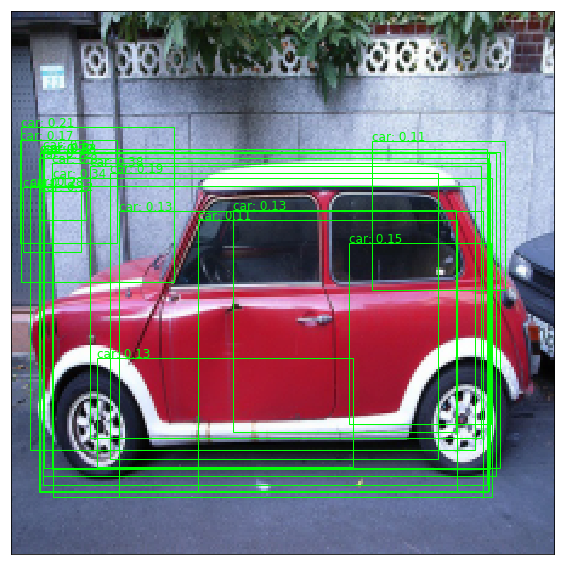

In [38]:
for im, bb, lab in zip(denormed_ims, bb_to_plot, lab_to_plot):
    voc.explore.plot_multiobject_results(im, bb, lab, pm_anc_tensor / 244, label2class, threshold=0.1, use_nms=False)

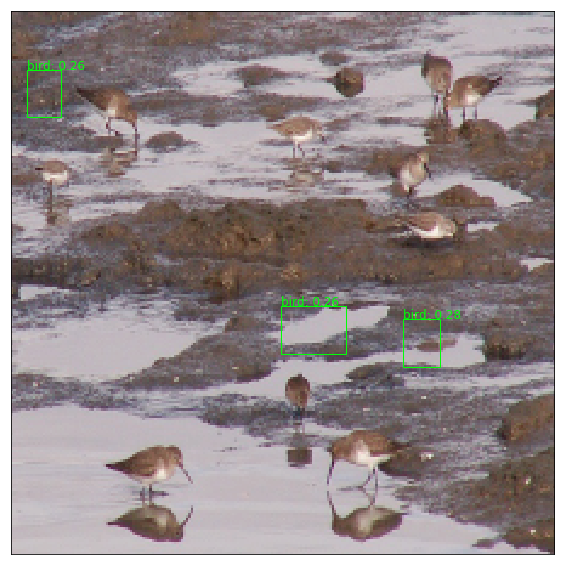

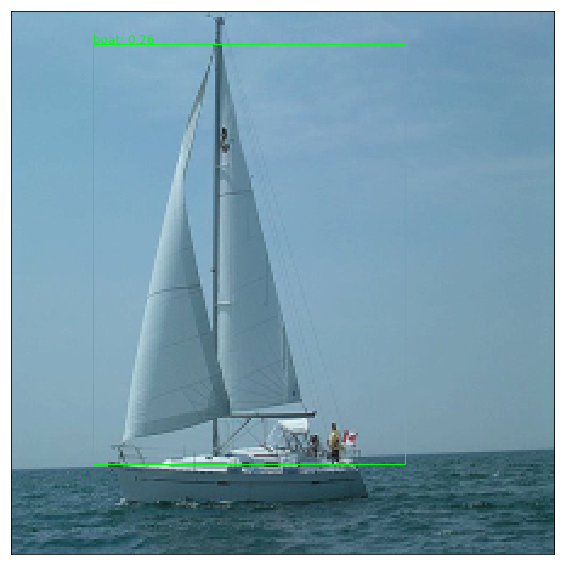

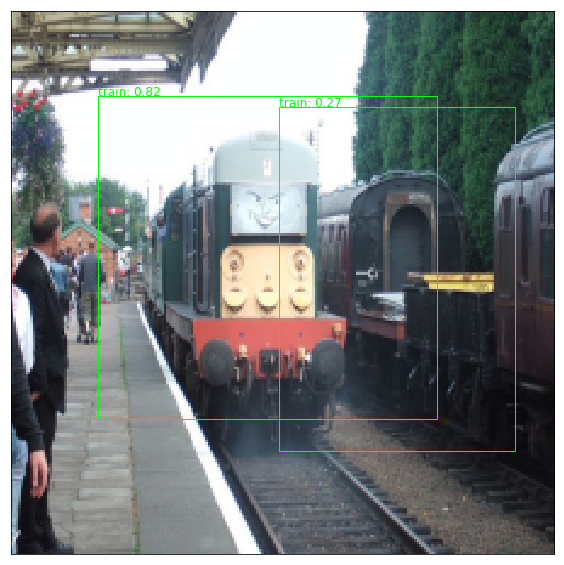

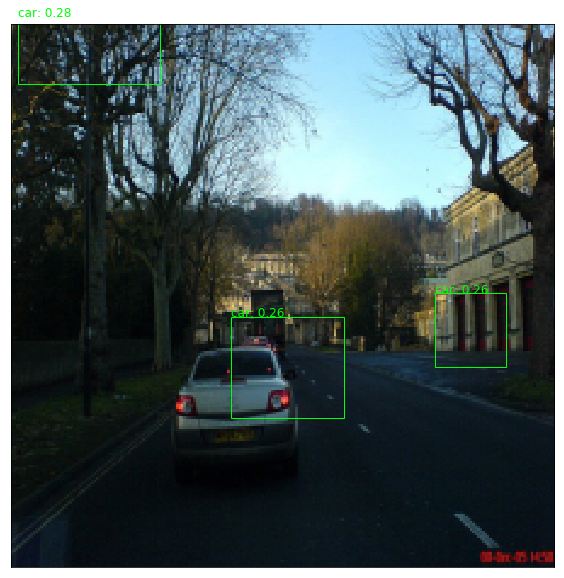

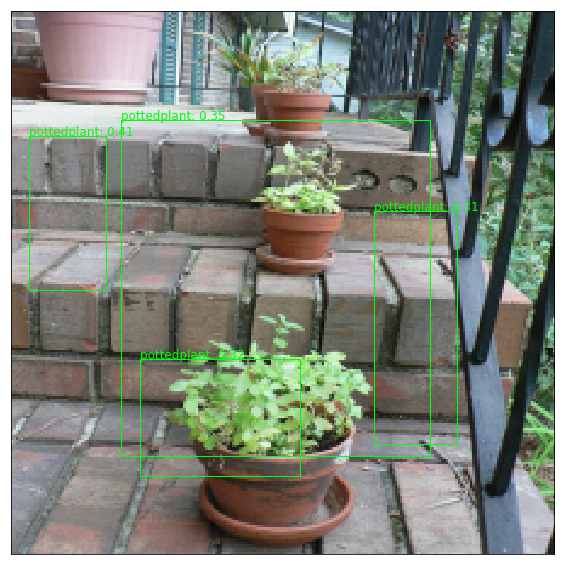

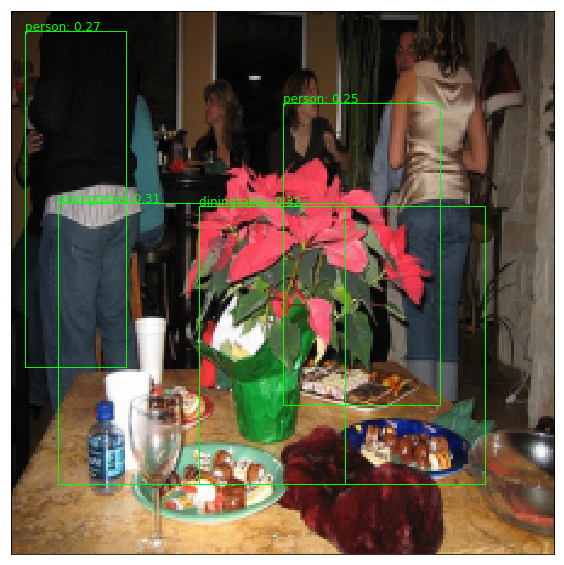

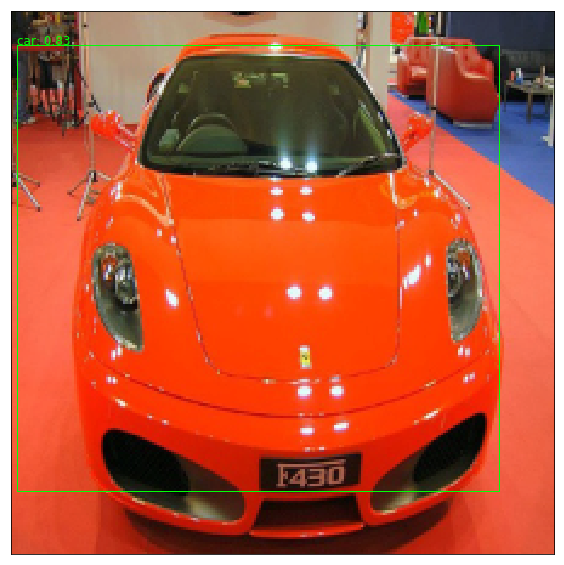

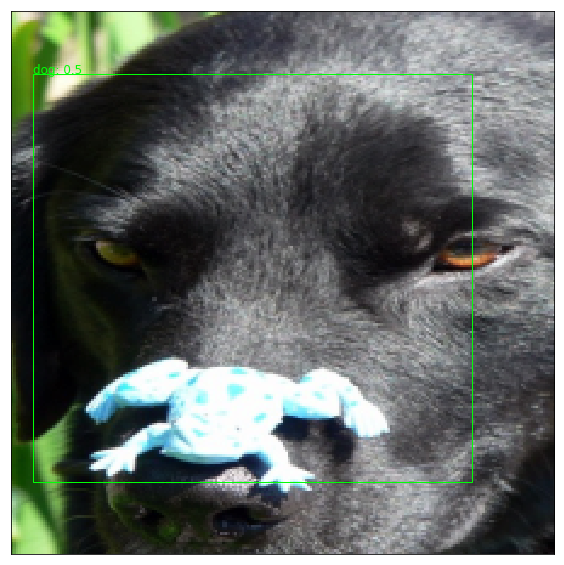

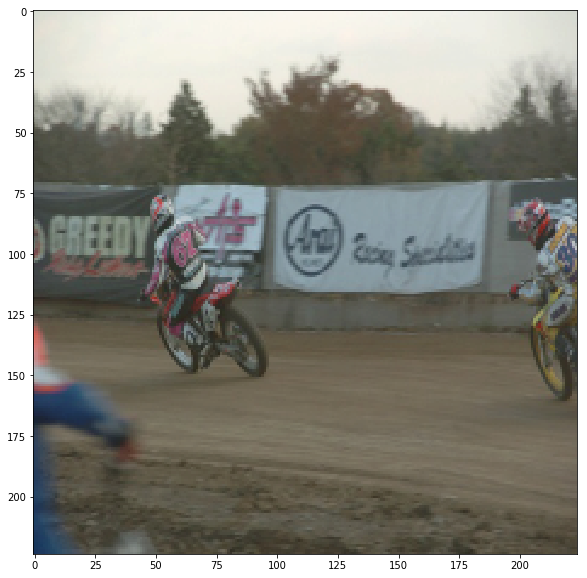

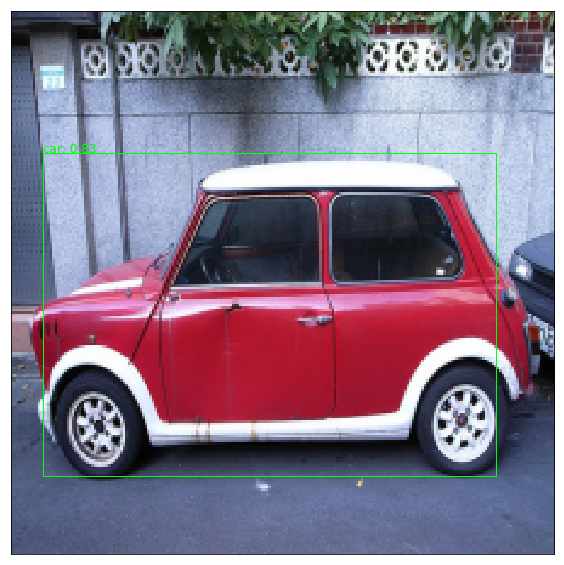

In [42]:
for im, bb, lab in zip(denormed_ims, bb_to_plot, lab_to_plot):
    voc.explore.plot_multiobject_results(im, bb, lab, pm_anc_tensor / 244, label2class, threshold=0.25)